In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch as th

In [14]:
def load_labels(
    csv_meniscus_filepath : str,
    csv_acl_filepath : str,
    csv_abnormal_filepath : str,
) -> dict :
    
    df_meniscus = pd.read_csv(csv_meniscus_filepath, dtype={0: str}, header=None)
    df_acl = pd.read_csv(csv_acl_filepath, dtype={0: str}, header=None)
    df_abnormal = pd.read_csv(csv_abnormal_filepath, dtype={0: str}, header=None)
    
    return {
        "df_meniscus" : df_meniscus,
        "df_acl" : df_acl,
        "df_abnormal" : df_abnormal,
    }

In [9]:
def transform_labels(
    df_meniscus : pd.DataFrame,
    df_acl : pd.DataFrame,
    df_abnormal : pd.DataFrame,
) -> pd.DataFrame :
    
    df_meniscus = df_meniscus.rename(columns={0 : "PatientID", 1: "Meniscus"})
    df_acl = df_acl.rename(columns={0 : "PatientID", 1: "ACL"})
    df_abnormal = df_abnormal.rename(columns={0 : "PatientID", 1: "Abnormal"})
    
    return df_meniscus.merge(df_acl, on="PatientID").merge(df_abnormal, on="PatientID")

In [15]:
df_train = transform_labels(
    **load_labels(
        csv_meniscus_filepath="data/labels/train-meniscus.csv",
        csv_acl_filepath="data/labels/train-acl.csv",
        csv_abnormal_filepath="data/labels/train-abnormal.csv",
    ),
)

display(df_train)

,PatientID,Meniscus,ACL,Abnormal
0,0000,0,0,1
1,0001,1,1,1
2,0002,0,0,1
3,0003,1,0,1
4,0004,0,0,1
5,0005,1,0,1


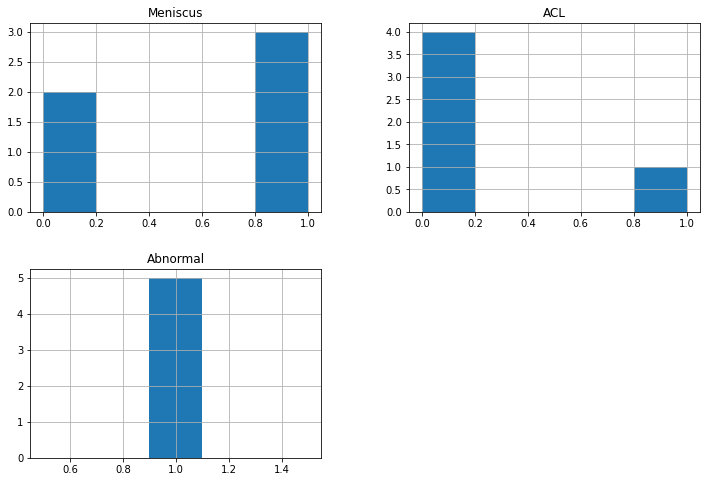

In [3]:
df_train[["Meniscus", "ACL", "Abnormal"]].hist(bins=5, figsize=(12, 8))
plt.show()

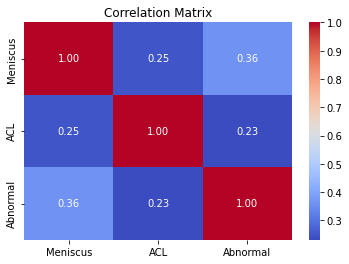

In [4]:
sns.heatmap(df_train[["Meniscus", "ACL", "Abnormal"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

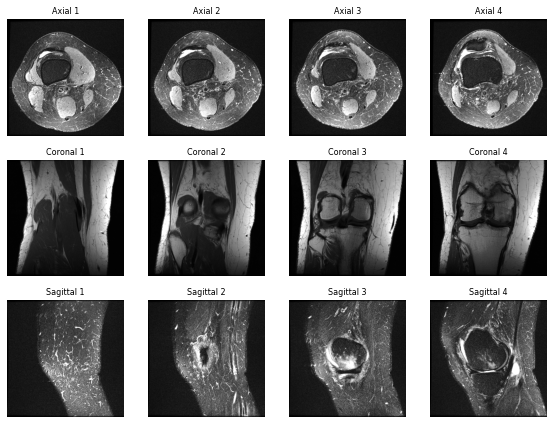

In [10]:

rmi_axial = np.load("data/train/axial/0000.npy")
rmi_coronal = np.load("data/train/coronal/0000.npy")
rmi_sagittal = np.load("data/train/sagittal/0000.npy")

mri_series = [rmi_axial, rmi_coronal, rmi_sagittal]
series_names = ["Axial", "Coronal", "Sagittal"]

n_rows = len(mri_series)
n_cols = 4
image_size = (128, 128)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for row, (series, name) in enumerate(zip(mri_series, series_names)):
    for col in range(n_cols):
        ax = axes[row, col]

        if col < series.shape[0]:
            image = series[3 + col*3]
            ax.imshow(image, cmap="gray")
            ax.set_title(f"{name} {col+1}", fontsize=8)
            ax.axis("off")
        else:
            ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
def check_series(data_dir, name):
    max_seq_length = 0
    min_seq_length = float('inf')
    IMAGE_SHAPE = 256
    are_all_images_same_shape = True

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".npy"):
            image = np.load(os.path.join(data_dir, file_name))
            if(image.shape[0] > max_seq_length):
                max_seq_length = image.shape[0]
            if(image.shape[0] < min_seq_length):
                min_seq_length = image.shape[0]
            if(image.shape[1] != IMAGE_SHAPE or image.shape[2] != IMAGE_SHAPE):
                are_all_images_same_shape = False
                
    print(name, ": max series length", max_seq_length)
    print(name, ": min seq length", min_seq_length)
    print(name, ": all images same size (256x256)", are_all_images_same_shape, "\n")

check_series(data_dir="MRNet-v1.0/train/axial/", name="Axial")
check_series(data_dir="MRNet-v1.0/train/coronal/", name="Coronal")
check_series(data_dir="MRNet-v1.0/train/sagittal/", name="Sagittal")

Axial : max series length 61
Axial : min seq length 19
Axial : all images same size (256x256) True 

Coronal : max series length 58
Coronal : min seq length 17
Coronal : all images same size (256x256) True 

Sagittal : max series length 51
Sagittal : min seq length 17
Sagittal : all images same size (256x256) True 



In [7]:
"""def save_series_to_memmap(
    memmap_file="memmap_mrnet.dat",
    source_dir="MRNet-v1.0/train/"
    ):
    files_axial =  sorted([(source_dir + "axial/" + f) for f in os.listdir(source_dir + "axial/") if f.endswith(".npy")])
    files_coronal =  sorted([(source_dir + "coronal/" + f) for f in os.listdir(source_dir + "coronal/") if f.endswith(".npy")])  
    files_sagittal =  sorted([(source_dir + "sagittal/" + f) for f in os.listdir(source_dir + "sagittal/") if f.endswith(".npy")])
    if not(len(files_axial) == len(files_coronal) == len(files_sagittal)):
        raise Exception("Patients number in series is diffrent")
    
    SERIES_LENGTH = 70 
    file_shape = (len(files_axial), 3, SERIES_LENGTH, 256, 256)
    dtype = np.float32
    memmap_file = np.memmap(memmap_file, dtype=dtype, mode="w+", shape=file_shape)
    print("Created memmap data file of shape", memmap_file.shape)

    
    for i in range(len(files_axial)):
        data_axial = np.load(files_axial[i])
        data_axial = data_axial/255
        data_axial = np.append(data_axial, np.zeros(shape=(SERIES_LENGTH-len(data_axial))), axis=0)
        
        data_coronal = np.load(files_coronal[i])
        data_coronal = data_coronal/255
        data_coronal = np.append(data_coronal, np.zeros(shape=(SERIES_LENGTH-len(data_coronal))), axis=0)
        
        data_sagittal = np.load(files_sagittal[i])
        data_sagittal = data_sagittal/255
        data_sagittal = np.append(data_sagittal, np.zeros(shape=(SERIES_LENGTH-len(data_sagittal))), axis=0)
        
        memmap_file[i] = np.array([data_axial, data_coronal, data_sagittal])

    del memmap_file
    print("Saved memmap file")
    
save_series_to_memmap()"""

'def save_series_to_memmap(\n    memmap_file="memmap_mrnet.dat",\n    source_dir="MRNet-v1.0/train/"\n    ):\n    files_axial =  sorted([(source_dir + "axial/" + f) for f in os.listdir(source_dir + "axial/") if f.endswith(".npy")])\n    files_coronal =  sorted([(source_dir + "coronal/" + f) for f in os.listdir(source_dir + "coronal/") if f.endswith(".npy")])  \n    files_sagittal =  sorted([(source_dir + "sagittal/" + f) for f in os.listdir(source_dir + "sagittal/") if f.endswith(".npy")])\n    if not(len(files_axial) == len(files_coronal) == len(files_sagittal)):\n        raise Exception("Patients number in series is diffrent")\n    \n    SERIES_LENGTH = 70 \n    file_shape = (len(files_axial), 3, SERIES_LENGTH, 256, 256)\n    dtype = np.float32\n    memmap_file = np.memmap(memmap_file, dtype=dtype, mode="w+", shape=file_shape)\n    print("Created memmap data file of shape", memmap_file.shape)\n\n    \n    for i in range(len(files_axial)):\n        data_axial = np.load(files_axial[i])

In [8]:
class MRIDataset(Dataset):
    def __init__(self, directory="MRNet-v1.0/train/", transform=None):
        self.files_axial =  sorted([
            (directory + "axial/" + f) 
            for f in os.listdir(directory + "axial/") 
            if f.endswith(".npy")
        ])
        self.files_coronal =  sorted([
            (directory + "coronal/" + f) 
            for f in os.listdir(directory + "coronal/") 
            if f.endswith(".npy")
        ])  
        self.files_sagittal =  sorted([
            (directory + "sagittal/" + f) 
            for f in os.listdir(directory + "sagittal/") 
            if f.endswith(".npy")
        ])
        self.SERIES_LENGTH = 70
        self.shape = (3, self.SERIES_LENGTH, 256, 256)
        self.transform = transform

    def __len__(self):
        return len(self.files_axial)

    def __getitem__(self, idx):
        data_axial = np.load(self.files_axial[idx])/255
        data_axial = np.append(
            data_axial,
            np.zeros(shape=(self.SERIES_LENGTH - len(data_axial), 256, 256)),
            axis=0
        )
        
        data_cornal = np.load(self.files_coronal[idx])/255
        data_cornal = np.append(
            data_cornal,
            np.zeros(shape=(self.SERIES_LENGTH - len(data_cornal), 256, 256)),
            axis=0
        )
        
        data_sagittal = np.load(self.files_sagittal[idx])/255
        data_sagittal = np.append(
            data_sagittal,
            np.zeros(shape=(self.SERIES_LENGTH - len(data_sagittal), 256, 256)),
            axis=0
        )
        
        sample = np.array([data_axial, data_cornal, data_sagittal])
        if self.transform:
            sample = self.transform(sample)
        return th.tensor(sample)

In [9]:
dataset = MRIDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

data_iter = iter(dataloader)
batch = next(data_iter)

print(f"Batch shape: {batch.shape}")
print(f"Batch data: {batch}")

Batch shape: torch.Size([16, 3, 70, 256, 256])
Batch data: tensor([[[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0235, 0.0196],
           [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0510, 0.0510],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0549, 0.0667],
           [0.0000, 0.0000, 0.0000,  ..., 0.0353, 0.0392, 0.0392],
           [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0275, 0.0235]],

          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
           [0.0000, 0.0000, 0.0000,  ..., 0.0392, 0.0353, 0.0353],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.0510, 0.0549],
           [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0431, 0.0549],
           [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0196]],

          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000